# Image processing in OpenCV and Jupyter

The image processing library OpenCV provides a very powerful Python interface, that we will explore in the sequel.

In [1]:
# Import OpenCV
import cv2
# Since OpenCV is based on numpy:
import numpy as np
# Import pyplot (we will need this to plot with the notebook)
import matplotlib.pyplot as plt
# Helper function to provide plots in true colors in the notebook
def imshow(title, im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.title(title)

## Reading and display of images

The input and output of images in opencv is rather easy, with files being easy to read via ```imread()``` and a combination of 
~~~(Python)
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
imshow('Webcam', frame)
~~~
suffices to open the webcam and display an image. Further cameras can be accessed by increasing the integer in ```cv2.VideoCapture(0)```.

In [2]:
im = cv2.imread('figures/teacher.png')

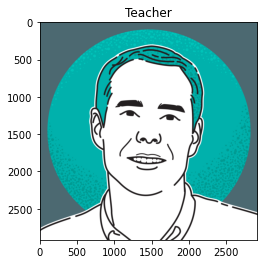

In [3]:
imshow('Teacher', im)

<function VideoCapture.release>

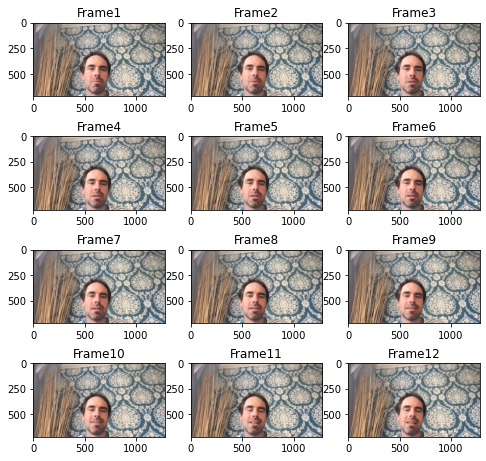

In [6]:
plt.figure(figsize=(8,8))
for i in range(1,13):
    cap = cv2.VideoCapture(0)
    ret, frame = cap.read()
    plt.subplot(4,3,i)
    imshow('Frame' + str(i), frame)
cap.release

## Data format

The images are stored as arrays. Color images are arrays of height x width x 3 (for each color.

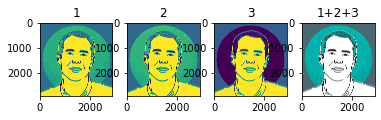

In [7]:
for i in range(0,3):
    plt.subplot(1,4,i+1)
    plt.imshow(im[:,:,i])
    plt.title(str(i+1))
plt.subplot(1,4,4)
imshow('1+2+3',im)

This means that it is relatively easy to access only portions of an image:

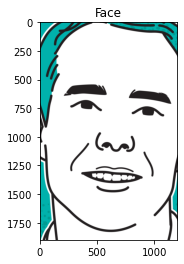

In [8]:
imshow('Face',im[500:2400, 800:2000,:])

It is of course possible to store this sub-image into a new frame:

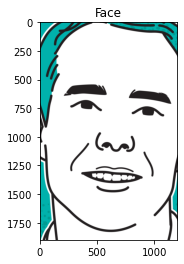

In [9]:
face = im[500:2400, 800:2000,:]
imshow('Face', face)

## Exercise

Try to show the mouth only.

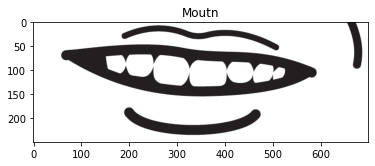

In [11]:
mouth = im[1750:2000, 1100:1800,:]
imshow('Moutn', mouth)

## Size transformation

Using the ```resize()```function, a quick and easy resizing is possible. It accepts a tuple of integer values, in the case at hand ```(int(0.125*w), int(0.125*h))``` to scale the image down to 1/8th of its original size. For this it is handy to use ```im.shape``` to find the original size.

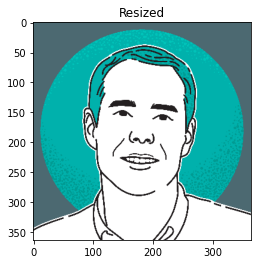

In [12]:
h,w,c = im.shape
im = cv2.resize(im, (int(0.125*w), int(0.125*h)))
imshow('Resized', im)

## Color transformation 

The standard colorspace in OpenCV is BGR, i.e. Blue-Green-Red. The most common conversion between colorspaces it the transformation from color to black and white:

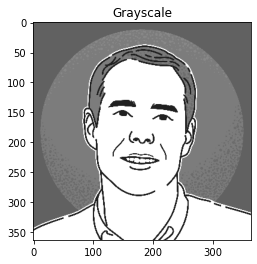

In [13]:
imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
imshow('Grayscale', imGray)

This can be further transformed to black and white by thresholding 

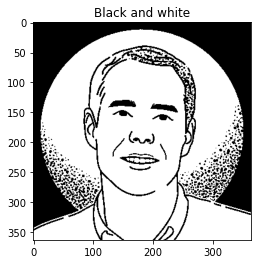

In [14]:
ret,imBW = cv2.threshold(imGray,120,255,cv2.THRESH_BINARY)
imshow('Black and white', imBW)

## Exercise

Experiment with different threshold values.

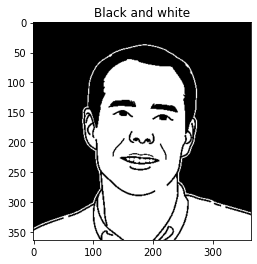

In [15]:
ret,imBW = cv2.threshold(imGray,180,255,cv2.THRESH_BINARY)
imshow('Black and white', imBW)

## Image smoothing

It is frequently necessary to smoothen images in order to get rid of too many details, or to pronounce other. A quite common and useful filter is the Gaussian blur, which blur the image by convolution with a 2D-Gaussian distribution. Input parameters are convolution kernel size (have to be odd!) and standard deviation.

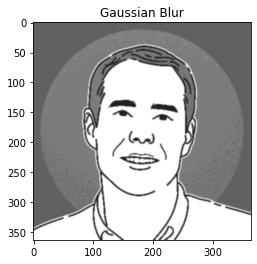

In [16]:
imBlur = cv2.GaussianBlur(imGray,(3,3), 1)
imshow('Gaussian Blur', imBlur)

## Exercise

Experiment with different kernel size and standard deviation.

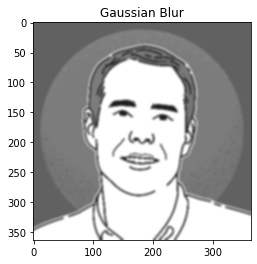

In [17]:
imBlur = cv2.GaussianBlur(imGray,(7,7), 2)
imshow('Gaussian Blur', imBlur)

## Morphological operations

The presence of a black and white image, containing only 0 and 1 entries, paves the way to morphological operations, i.e. eroding and dilating image values. Erosion, as the name suggests, removes the outer white areas according to a kernel shape and size. Dilation connects white regions and thins out lines.

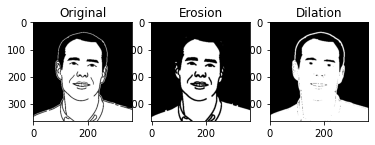

In [18]:
kernel = np.ones((3,3),np.uint8)
imEr = cv2.erode(imBW,kernel,iterations = 1)
imDil = cv2.dilate(imBW,kernel,iterations = 1)
plt.subplot(131)
imshow('Original', imBW)
plt.subplot(132)
imshow('Erosion', imEr)
plt.subplot(133)
imshow('Dilation', imDil)

As we can see, the erosion mostly turns the grayish area above the shoulders black, while dilation mostly removes it. There are many more morphological operations available, however with erosion and dilation, most of tasks can be achieved.

## Exercise

Try different kernel sizes, also non-symmetric ones and observe the effects. Try to remove the whole face except for the eyebrows.

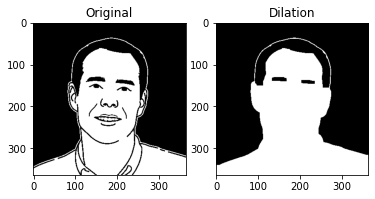

In [26]:
kernel = np.ones((7,15),np.uint8)
imBrows = cv2.dilate(imBW,kernel,iterations = 1)
imBrows = cv2.erode(imBrows,kernel,iterations = 1)
plt.subplot(121)
imshow('Original', imBW)
plt.subplot(122), 'Brows dilation', imBrows)

---

## Image gradients

A further important concept is the idea of gradients in images, i.e. discrete derivatives between pixels. It is mostly used in a Canny filter, which combines five steps:

1. Apply Gaussian filter to smooth the image in order to remove the noise
1. Find the intensity gradients of the image using Sobel differentials
1. Non-maximum suppression
1. Hysteresis thresholding: the pixels with gradients above the upper threshold are sure to be edges, those below the lower bound are sure to be non-edges. Those between are decided based on their connectivity: if they are connected to sure-edge pixels, they are edges, otherwise not.

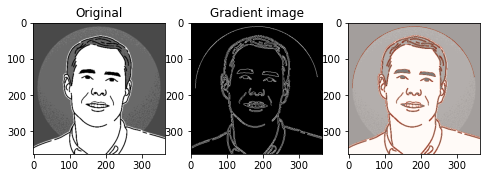

In [27]:
imGrad = cv2.Canny(imGray,100,200)
plt.figure(figsize=(8,16))
plt.subplot(131)
plt.imshow(imGray, cmap = 'gray')
plt.title('Original')
plt.subplot(132)
plt.imshow(imGrad, cmap = 'gray')
plt.title('Gradient image')
plt.subplot(133)
plt.imshow(imGray, cmap = 'gray')
plt.imshow(imGrad, cmap = 'Reds', alpha = 0.5)


## Hough Line transformation

The idea behind Hough Line detection is to rotate the image and sum up the pixel values of all pixels in one direction, effectively transforming the image to its line space as depicted below:

![Hough result by Wikimedia/Daf-de](figures/Hough.png)

(Image by Wikimedia user Daf-de, CC-BY-SA 3.0)

This image clearly show the two maxima for both detected lines. For real world images, it is good to smooth these beforehand.

We will use a real world image as an example:

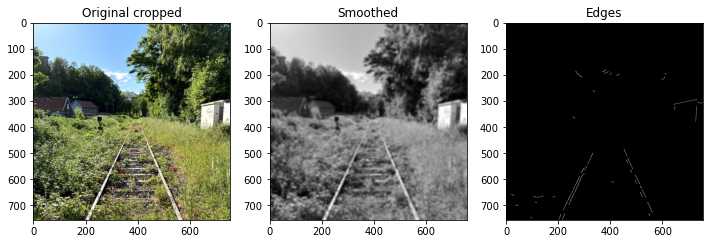

In [28]:
# Read image
im = cv2.imread('figures/Ruhrtalbahn.jpg')
# Reduce reduce resolution
h,w,c = im.shape
im = cv2.resize(im, (int(0.25*w), int(0.25*h)))
# Cropping: Exclude horizon, square image
h,w,c = im.shape
im = im[0:w,:,:]
h,w,c = im.shape
# Convert to gray image
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# Reduce plant edges by smoothing 
gray = cv2.GaussianBlur(gray,(11,11), 3)
# Apply Canny edge detector
edges = cv2.Canny(gray,170,220,apertureSize = 3)
# Plot
plt.figure(figsize=(12,8))
plt.subplot(131)
imshow('Original cropped', im)
plt.subplot(132)
imshow('Smoothed', gray)
plt.subplot(133)
imshow('Edges', edges)

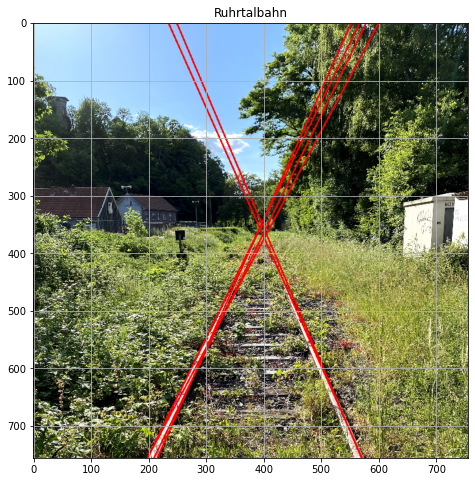

In [29]:
# Apply Hough Line detector on edges image
lines = cv2.HoughLines(edges,5,np.pi/180,200)
for rho,theta in lines[:,0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(im,(x1,y1),(x2,y2),(0,0,255),2)

plt.figure(figsize=(10,8))    
imshow('Ruhrtalbahn', im)
plt.grid()

---

## Perspective image transformation

We will use the inverse perspective mapping, which maps pixels $(u,v)$ in the image plane to cartesian $(x,y)$ coordinates.

This is achieved by help of a transformation mapping
$$\begin{bmatrix}x\\y\\w' \end{bmatrix} = \begin{bmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33}\end{bmatrix} \begin{bmatrix} u\\v\\w\end{bmatrix}$$,

for which the OpenCV function ```cv2.getPerspectiveTransform(src,dst)``` can supply a transformation matrix for an array of points. For straight rails, these can be read from the images by matching the bottom $x$ coordinate to the converging coordinate closer to the image horizon.

It appropriate to add zero-padding to the images since the remote end will be considerably distorted.

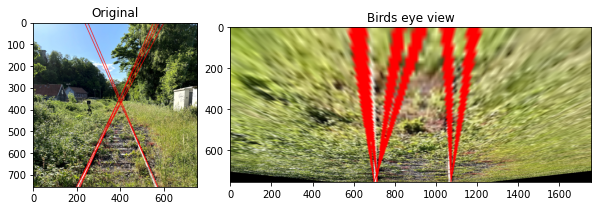

In [62]:
# Read image
im = cv2.imread('figures/Ruhrtalbahn.jpg')
# Reduce reduce resolution
h,w,c = im.shape
im = cv2.resize(im, (int(0.25*w), int(0.25*h)))
# Cropping: Exclude horizon, square image
h,w,c = im.shape
im = im[0:w,:,:]
ih,iw,l = im.shape

pad = 500
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
impadded = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_CONSTANT, 0)
graypadded = cv2.copyMakeBorder(imgray, 0, 0, pad, pad, cv2.BORDER_CONSTANT, 0)
#######################
# Birds eye transformation
# Points for transformation
src = np.float32([[pad+203,ih], [pad+377,400],  [pad+570,ih], [pad+414,400]])
dst = np.float32([[pad+203,ih], [pad+203,400],  [pad+570,ih], [pad+570,400]])
# Transformation matrix
M = cv2.getPerspectiveTransform(src,dst)
# Transformation
warped = cv2.warpPerspective(impadded, M, (iw+2*pad,ih))
# Plotting
plt.figure(figsize = (10,20))
plt.subplot(131)
imshow('Original', im)
plt.subplot(1,3,(2,3))
imshow('Birds eye view', warped)

## Exercise

Load the image 'figures/LevelCrossing.png'. Display and inspect it. 

Apply grayscale filtering, smoothing, edge and line dectection in order to find the rails. Apply birds eye transformation to the image with rail lines.

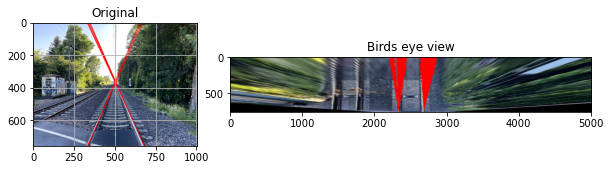

In [70]:
# Read image
im = cv2.imread('figures/LevelCrossing.jpg')
# Reduce reduce resolution
h,w,c = im.shape
im = cv2.resize(im, (int(0.25*w), int(0.25*h)))
# Cropping: Exclude horizon, square image
h,w,c = im.shape
im = im[0:w,:,:]
ih,iw,l = im.shape

# Convert to gray image
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# Reduce plant edges by smoothing 
gray = cv2.GaussianBlur(gray,(11,11), 3)
# Apply Canny edge detector
edges = cv2.Canny(gray,170,220,apertureSize = 3)

# Apply Hough Line detector on edges image
lines = cv2.HoughLines(edges,5,np.pi/1800,290)
for rho,theta in lines[:,0]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(im,(x1,y1),(x2,y2),(0,0,255),2)

pad = 2000
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
impadded = cv2.copyMakeBorder(im, 0, 0, pad, pad, cv2.BORDER_CONSTANT, 0)
graypadded = cv2.copyMakeBorder(imgray, 0, 0, pad, pad, cv2.BORDER_CONSTANT, 0)
#######################
# Birds eye transformation
# Points for transformation
src = np.float32([[pad+320,ih], [pad+487,400],  [pad+665,ih], [pad+515,400]])
dst = np.float32([[pad+320,ih], [pad+320,400],  [pad+665,ih], [pad+665,400]])
# Transformation matrix
M = cv2.getPerspectiveTransform(src,dst)
# Transformation
warped = cv2.warpPerspective(impadded, M, (iw+2*pad,ih))
# Plotting
plt.figure(figsize = (10,20))
plt.subplot(131)
imshow('Original', im)
plt.grid()
plt.subplot(1,3,(2,3))
imshow('Birds eye view', warped)